In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy
from contexttimer import Timer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from bandits import MetaBanditEnv
from exact import solve
from blinkered_bandits import blinkered

def parse(row):
    if row[0] < 0:
        return None
    row = row.tolist()
    arms = range(len(row) // 2)
    return tuple((row[a*2], row[a*2 + 1]) for a in arms)

template= '../matlab_code/GeneralMDP/states{n_arm}{max_obs}.csv'

def make_df(n_arm):
    max_obs = 10
    cost = 0
    env = MetaBanditEnv(n_arm, max_obs, cost)
    states = pd.read_csv(template.format(n_arm=n_arm, max_obs=max_obs))
    states = states.apply(parse, axis=1).iloc[:-1]

    Q, V, pi, info = solve(env)
    
    def get_qs(s):
        if len(env.actions(s)) == 1:
            return [0] * n_arm + [Q(s, n_arm)]
        else:
            return [Q(s, a) for a in range(n_arm+1)]

    return pd.DataFrame(np.stack(states.apply(get_qs)))

def write_csvs():
    for n_arm in range(2, 6):
        df = make_df(n_arm)
        df.to_csv('results/bandit_q_{n_arm}_{max_obs}.csv'.format(n_arm=n_arm, max_obs=max_obs),
                  header=False, index=False)


In [41]:
import time
def timed(method):

    def dec(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print('%r %2.2f sec' % (method.__name__, te-ts))
        return result

    return dec

In [21]:
%%time
env = MetaBanditEnv(3, 26, 0.01)
Q, V, pi, info = solve(env, hash_state=lambda s: tuple(sorted(s)))
print(V(env.init))
info

0.6420228649995051
CPU times: user 8.14 s, sys: 102 ms, total: 8.24 s
Wall time: 8.3 s


# Solution Methods for the MDP

## Backwards Induction

### Long Horizon

In [149]:
%%time

def data():
    for n_arm in range(2, 5):
        for max_obs in np.logspace(1, 5, 5, base=2):
            for cost in [0.0001, 0.001, .01]:
                env = MetaBanditEnv(n_arm, max_obs, cost)
                Q, V, pi, info = solve(env, hash_state=lambda s: tuple(sorted(s)))
                with Timer() as timer:
                    v = V(env.init)
                    t = timer.elapsed
                yield dict(
                    n_arm=n_arm,
                    max_obs=max_obs,
                    cost=cost,
                    time=t,
                    v=v,
                )
                
df = pd.DataFrame(data())

CPU times: user 14min 19s, sys: 19.6 s, total: 14min 39s
Wall time: 14min 56s


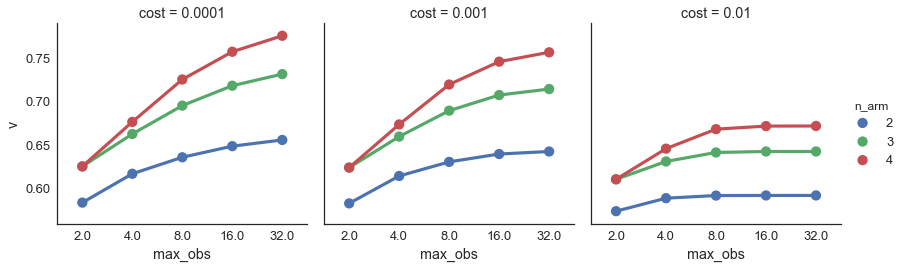

In [153]:
sns.factorplot('max_obs', 'v', hue='n_arm', data=df, col='cost')

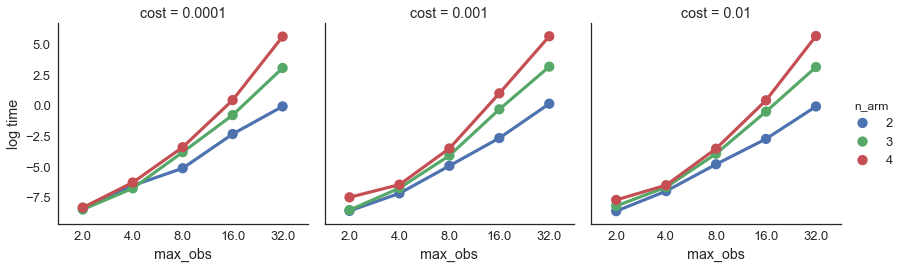

In [183]:
df['log time'] = np.log(df.time)
sns.factorplot('max_obs', 'log time', hue='n_arm', data=df, col='cost')

### Many Arms

In [28]:
%%time

def data():
    for n_arm in range(2, 11):
        for max_obs in np.logspace(1, 4, 4, base=2):
            for cost in [0.0001, 0.001, .01]:
                env = MetaBanditEnv(n_arm, max_obs, cost)
                Q, V, pi, info = solve(env, hash_state=lambda s: tuple(sorted(s)))
                with Timer() as timer:
                    v = V(env.init)
                    t = timer.elapsed
                yield dict(
                    n_arm=n_arm,
                    max_obs=max_obs,
                    cost=cost,
                    time=t,
                    v=v,
                )
                
df = pd.DataFrame(data())

CPU times: user 2min 50s, sys: 6.68 s, total: 2min 56s
Wall time: 2min 59s


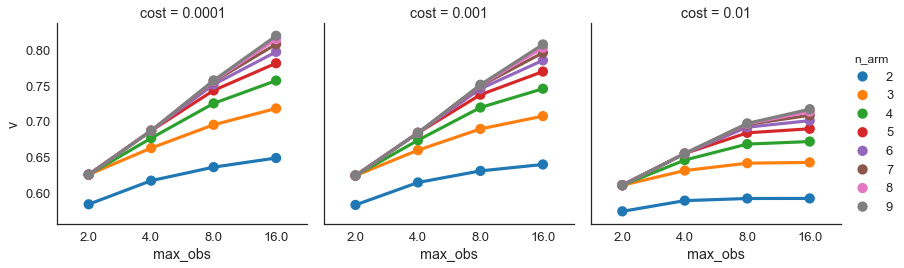

In [29]:
sns.factorplot('max_obs', 'v', hue='n_arm', data=df, col='cost')

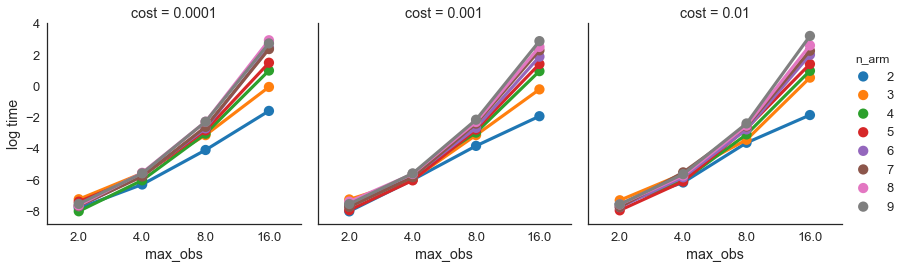

In [31]:
df['log time'] = np.log(df.time)
sns.factorplot('max_obs', 'log time', hue='n_arm', data=df, col='cost')

# Blinkered Approximation

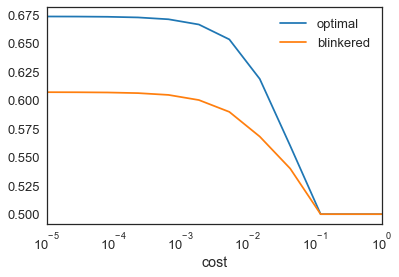

In [34]:
def data():
    n_arm = 3
    max_obs = 5
    for cost in np.logspace(-5, 0, 12):
        env = MetaBanditEnv(n_arm, max_obs, cost)
        yield {'optimal': solve(env)[1](env.init),
               'blinkered': blinkered(env)[1](env.init),
               'cost': cost,
               'n_arm': n_arm,
               'max_obs': max_obs}
        
df = pd.DataFrame(data())
df.set_index('cost')[['optimal', 'blinkered']].plot()
ax = plt.gca()
ax.set_xscale('log')

In [35]:
df.cost

0     0.000010
1     0.000028
2     0.000081
3     0.000231
4     0.000658
5     0.001874
6     0.005337
7     0.015199
8     0.043288
9     0.123285
10    0.351119
11    1.000000
Name: cost, dtype: float64

In [36]:
df

,blinkered,cost,max_obs,n_arm,optimal
0,0.607106,0.000010,5,3,0.673573
1,0.607037,0.000028,5,3,0.673504
2,0.606843,0.000081,5,3,0.673305
3,0.606288,0.000231,5,3,0.672738
4,0.604709,0.000658,5,3,0.671126
5,0.600210,0.001874,5,3,0.666532
6,0.589819,0.005337,5,3,0.653450
7,0.568134,0.015199,5,3,0.618747
8,0.540046,0.043288,5,3,0.560069
9,0.500000,0.123285,5,3,0.500000


In [37]:
from blinkered_bandits import blinkered
env = MetaBanditEnv(3, 10, .01)
Q, V, pi, info = solve(env)

Q1, V1, pi1, info1 = blinkered(env)
V1(env.init), V(env.init)

(0.5767619047619048, 0.6416982804232804)

# Regression

In [38]:
from collections import defaultdict
from toolz import memoize

def hash_key(args, kwargs):
    s = args[0]
    if s is None:
        return s
    else:
        return tuple(sorted(s))
    
def regression_data(env):
    Q, V, pi, info = solve(env, hash_state=lambda s: tuple(sorted(s)))
    data = []
    @memoize(key=hash_key)
    def rec(s):
        for a in env.actions(s):
            data.append({
                    'features': env.action_features(a, state=s),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
            })
            for p, s1, r in env.results(s, a):
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)


def big_regression():
    for cost in np.logspace(-2.5, 0.5, 5):
        env = make_env(2, cost, None)
        df = pd.DataFrame(regression_data(env))
        yield df

In [39]:
n_arm = 2
max_obs = 8
cost = 0.001
env = MetaBanditEnv(n_arm, max_obs, cost)
df = regression_data(env)
df[:10]

,action,features,q_star,state
0,0,"[-0.001, 0.0833333333333, 0.124703484419, 0.16...",0.630070,"((1, 1), (1, 1))"
1,0,"[-0.001, 1.11022302463e-16, 0.0404148663084, 0...",0.714404,"((2, 1), (1, 1))"
2,0,"[-0.001, 1.11022302463e-16, 0.0153882033285, 0...",0.769336,"((3, 1), (1, 1))"
3,0,"[-0.001, 0.0, 0.00555688854965, 0.033499330390...",0.807383,"((4, 1), (1, 1))"
4,0,"[-0.001, 0.0, 0.00254239179499, 0.024091812865...",0.835599,"((5, 1), (1, 1))"
5,0,"[-0.001, 1.11022302463e-16, 0.00156984888595, ...",0.856143,"((6, 1), (1, 1))"
6,0,"[-0.001, -1.11022302463e-16, 0.000694408996298...",0.874000,"((7, 1), (1, 1))"
7,0,"[-0.001, 0.0, 0.000370104512554, 0.01106837020...",0.887889,"((8, 1), (1, 1))"
8,2,"[0.0, 0.0, 0.0, 0.0, 0.9]",0.900000,"((9, 1), (1, 1))"
9,2,"[0.0, 0.0, 0.0, 0.0, 0.8]",0.800000,"((8, 2), (1, 1))"


In [40]:
from sklearn.linear_model import LinearRegression

def run_regression(df):
    X = np.stack(df.features)
#     X[:, 0] = 1
#     X[:, -1] = 1
    m = LinearRegression().fit(X, df.q_star)
    df['q_hat'] = m.predict(X)
    df['abs_error'] = np.abs(df['q_hat'] - df['q_star'])
    return m.coef_

print(run_regression(df))
df.abs_error.mean()

[ 7.21   0.847 -0.137  0.387  1.003]


0.004187216888441326

## Bayesian Optimization

In [44]:
from policies import WeightedPolicy
from skopt import gp_minimize

def x2theta(x):
    assert len(x) == 5
    cost_weight = x[0]
    voi_weights = np.array(x[1:])
    # voi_weights /= voi_weights.sum()
    term_weight = 1
    return np.array([cost_weight, *voi_weights, term_weight])
    
@timed
def bo_policy(envs, n_calls=60, verbose=False):
#     bounds = [ (1., 3.)] + [ (0., 1.) ] * 3
    bounds = [(-2., 2.)] * 5
    def objective(x):
        theta = x2theta(x)
        util = evaluate(WeightedPolicy(theta), envs).util.mean()
        if verbose:
            print(theta.round(3), util)
        # regularize = 0.01 * (theta ** 2).sum()
        regularize = 0
        return - (util - regularize)
    
    result = gp_minimize(objective, bounds, n_calls=n_calls, random_state=0)
    theta = x2theta(result.x)
    print('theta:', theta.round(3))
    return MouselabPolicy(theta)

ModuleNotFoundError: No module named 'skopt'

# Evaluation

In [43]:
agent = Agent()
def run_env(policy, env):
    agent.register(policy)
    agent.register(env)
    tr = agent.run_episode()
    return {'util': tr['return'],
            'observations': len(tr['actions']) - 1}

def evaluate(policy, envs):
    return pd.DataFrame(run_env(policy, env) for env in envs)

In [37]:
state = ((1,4),(1,1))
df[df['state' == state]

0.50760238095238097

In [42]:
pol = df[['state','action']].iloc[df.groupby('state', sort=False)['q_star'].idxmax()]
pol[:10]

,state,action
0,"((1, 1), (1, 1))",0
1,"((2, 1), (1, 1))",0
2,"((3, 1), (1, 1))",0
218,"((4, 1), (1, 1))",1
4,"((5, 1), (1, 1))",0
69,"((6, 1), (1, 1))",2
30,"((7, 1), (1, 1))",2
13,"((8, 1), (1, 1))",2
8,"((9, 1), (1, 1))",2
9,"((8, 2), (1, 1))",2
